In [ ]:
#Ambrose Nzioki Kimunyi
#COM/B/01-00174/2017

import numpy as np # linear algebra
import pandas as pd


In [ ]:
from google.colab import drive

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/sentiment/data.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 2.8 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:


!pip install keras --upgrade

In [ ]:
!pip install pandas --upgrade

     |████████████████████████████████| 11.3 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/sentiment/data.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 399 ms, sys: 6.16 ms, total: 405 ms
Wall time: 409 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

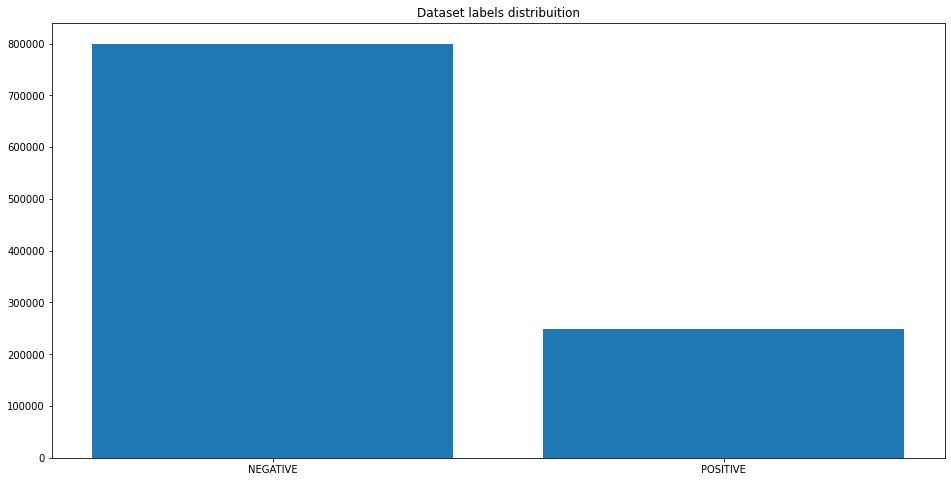

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 37.1 s, sys: 220 ms, total: 37.3 s
Wall time: 37.3 s


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 838860
TEST size: 209716


In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 1.84 s, sys: 236 ms, total: 2.08 s
Wall time: 2.07 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2021-11-18 05:30:38,139 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-11-18T05:30:38.139211', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [ ]:
w2v_model.build_vocab(documents)

2021-11-18 05:30:38,149 : INFO : collecting all words and their counts
2021-11-18 05:30:38,151 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-18 05:30:38,186 : INFO : PROGRESS: at sentence #10000, processed 73104 words, keeping 13623 word types
2021-11-18 05:30:38,211 : INFO : PROGRESS: at sentence #20000, processed 146981 words, keeping 20993 word types
2021-11-18 05:30:38,234 : INFO : PROGRESS: at sentence #30000, processed 219193 words, keeping 26962 word types
2021-11-18 05:30:38,262 : INFO : PROGRESS: at sentence #40000, processed 292064 words, keeping 31950 word types
2021-11-18 05:30:38,286 : INFO : PROGRESS: at sentence #50000, processed 365698 words, keeping 36559 word types
2021-11-18 05:30:38,314 : INFO : PROGRESS: at sentence #60000, processed 439216 words, keeping 40946 word types
2021-11-18 05:30:38,343 : INFO : PROGRESS: at sentence #70000, processed 511927 words, keeping 44983 word types
2021-11-18 05:30:38,369 : INFO : PROGRESS: at s

In [ ]:
 words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 23396


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=5)

2021-11-18 05:30:41,293 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 23396 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2021-11-18T05:30:41.293480', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-11-18 05:30:42,312 : INFO : EPOCH 1 - PROGRESS: at 6.03% examples, 326390 words/s, in_qsize 13, out_qsize 0
2021-11-18 05:30:43,326 : INFO : EPOCH 1 - PROGRESS: at 12.56% examples, 337298 words/s, in_qsize 16, out_qsize 0
2021-11-18 05:30:44,341 : INFO : EPOCH 1 - PROGRESS: at 19.27% examples, 343767 words/s, in_qsize 12, out_qsize 3
2021-11-18 05:30:45,389 : INFO : EPOCH 1 - PROGRESS: at 26.79% examples, 355172 words/s, in_qsize 13, out_qsize 2
2021-11-18 05:30:46,417 : INFO : EPOCH 1 - PROGRESS: at 33.82% examples, 357956 words/s, in_qsize 16, out_qsize 1
2021-11-18 05:30:

CPU times: user 2min 20s, sys: 1.07 s, total: 2min 21s
Wall time: 1min 13s


(26997241, 30554190)

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 210156
CPU times: user 12.3 s, sys: 117 ms, total: 12.4 s
Wall time: 12.4 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 18.6 s, sys: 734 ms, total: 19.3 s
Wall time: 19 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (838860, 1)
y_test (209716, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (838860, 300)
y_train (838860, 1)

x_test (209716, 300)
y_test (209716, 1)


In [ ]:
y_train[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(210156, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-11-18 05:32:33,464 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          63046800  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 63,207,301
Trainable params: 160,501
Non-trainable params: 63,046,800
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=1,
                    validation_split=0.4,
                    verbose=1,
                    callbacks=callbacks)

492/492 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8096WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2021-11-18 05:47:30,292 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


492/492 [==============================] - 896s 2s/step - loss: 0.4219 - accuracy: 0.8096 - val_loss: 0.3895 - val_accuracy: 0.8254 - lr: 0.0010
CPU times: user 20min 9s, sys: 3min 25s, total: 23min 35s
Wall time: 15min 25s


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

205/205 [==============================] - 48s 233ms/step - loss: 0.3882 - accuracy: 0.8272

ACCURACY: 0.8272044062614441
LOSS: 0.38818076252937317
CPU times: user 34.8 s, sys: 9.43 s, total: 44.3 s
Wall time: 47.8 s


In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("covid is real!")

{'elapsed_time': 0.1958293914794922,
 'label': 'POSITIVE',
 'score': 0.8528914451599121}

In [ ]:


predict("covid vaccines are good")

{'elapsed_time': 0.15865206718444824,
 'label': 'NEUTRAL',
 'score': 0.5499122142791748}

In [ ]:
predict("depression is real")

{'elapsed_time': 0.16440653800964355,
 'label': 'NEGATIVE',
 'score': 0.30039331316947937}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

27/27 [==============================] - 30s 1s/step
CPU times: user 18.5 s, sys: 12.3 s, total: 30.8 s
Wall time: 41.6 s


In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.8272044097732171

In [ ]:
model.save("/content/drive/MyDrive/sentiment/my_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!
